# The Catering Problem

## Motivation

A catering company to cook $n$ dishes, but has only one available oven.
    At most a single dish can be inside the oven at one time.    
    Each dish $i$ has its earliest time when it can be put into the oven $r_i$ (since it needs to be prepared before it is put into the oven), the latest time it should be taken from the oven $d_i$ (since the customers do not want to wait too long), and the time it needs to stay in the oven $p_i$.
    The goal is to find the vector of times $\mathbf{s} = (s_0, \dots, s_{n-1})$ (denoting the times when each dish is put into the oven) such that the finish time of the last dish is minimal.
    
## Input

You are given the following:
* number of dished $n$
* parameters $r_i$, $d_i$ and $p_i$ for each dish $i$

For the testing purposes, you can experiment with the following instance:

In [10]:
n = 5
params = {
    0: {'r': 20, 'd': 45, 'p': 15},
    1: {'r':  4, 'd': 30, 'p': 19},
    2: {'r':  5, 'd': 80, 'p': 20},
    3: {'r': 17, 'd': 70, 'p':  8},
    4: {'r': 27, 'd': 66, 'p':  7}
}

# Note: parameter d_1 can be obtained by params[1]["d"]

## Output

You are expected to find the vector $\mathbf{s} = (s_0, \dots, s_{n-1})$ denoting the times when each dish should be put into the oven.

The optimal solution vector for the given instance is $\mathbf{s} = (23, 4, 53, 38, 46)$.

## Exercise

Your task is to formulate the ILP model of the catering problem, solve it, and extract the vector $\mathbf{s}$. The example solution follows:

Hint: to ensure that any two dishes $i$ and $j$ are not overlapping in the oven, you need to ensure that one of the following constraints holds: $s_i + p_i \leq s_j$ or $s_j + p_j \leq s_i$. This might be perhaps done using big-M... 

In [11]:
import gurobipy as grb  # import Gurobi module

# model -----------------------------------------------------
model = grb.Model()

n = 5
params = {
    0: {'r': 20, 'd': 45, 'p': 15},
    1: {'r':  4, 'd': 30, 'p': 19},
    2: {'r':  5, 'd': 80, 'p': 20},
    3: {'r': 17, 'd': 70, 'p':  8},
    4: {'r': 27, 'd': 66, 'p':  7}
}

# - ADD VARIABLES
# lb = 0 (moc nemá smysl - lower bound)
s = model.addVars(n, vtype=grb.GRB.CONTINUOUS, lb=0, name="s")

# matrix = []
# for i in range (0,n):
#     row = []
#     matrix[i].append(row)
#     for j in range (0,n):
#         matrix[i][j].append(model.addVar(vtype=grb.GRB.BINARY, name="chrchel"))

x = {}

for i in range (n):
    for j in range (i):
        x [i, j] = model.addVar(vtype=grb.GRB.BINARY, name="chrchel")
# - ADD CONSTRAINTS
# each start musí být menší než konec
# s[t] >= r[t]
# každý konec musí být menší než deadlide
# s[t] + p[t] <= d[t]
# dáme si big M - každá dvojice bude mít binární operátor, který bude říkat, jestli dané jídlo je před jiným jídlem - podle 
Cmax = model.addVar(vtype=grb.GRB.CONTINUOUS, name="Cmax")

for i in range (n):
    model.addConstr(s[i]+params[i]["p"] <= Cmax)

    model.addConstr(s[i] >= params[i]["r"])
    model.addConstr(s[i] + params[i]["p"] <= params[i]["d"])

#ideál je použít za bigM největší deadline
bigM = 1000

for i in range (n):
    for j in range (i):
        model.addConstr(s[i]+params[i]["p"] <= s[j] + bigM * (1 - x[i, j]))
        model.addConstr(s[j]+params[j]["p"] <= s[i] + bigM * x[i, j])

# - SET OBJECTIVE
model.setObjective(Cmax, grb.GRB.MINIMIZE)

# call the solver -------------------------------------------
model.optimize()

# print the solution ----------------------------------------
print('\nSOLUTION:')
print(Cmax)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 35 rows, 16 columns and 80 nonzeros
Model fingerprint: 0x95bfa3ca
Variable types: 6 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 31 rows and 12 columns
Presolve time: 0.00s
Presolved: 4 rows, 4 columns, 10 nonzeros
Variable types: 3 continuous, 1 integer (1 binary)
Found heuristic solution: objective 73.0000000

Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 73 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.300000000000e+01, best bound 7.300000000000e+01, gap 0.0000%

SOLUTION:
<gurobi.Var Cmax (value 73.0)>


## Solution visualization

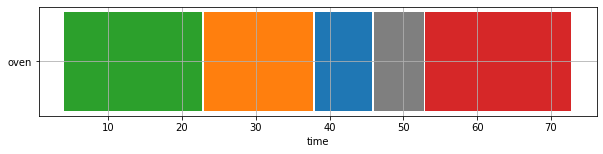

In [12]:
import matplotlib.pyplot as plt 

def plot_solution(s, p):
    """
    s: solution vector
    p: processing times
    """
    fig = plt.figure(figsize=(10,2))
    ax = plt.gca()
    ax.set_xlabel('time')     
    ax.grid(True) 
    ax.set_yticks([2.5])
    ax.set_yticklabels(["oven"]) 
    eps = 0.25  # just to show spaces between the dishes
    ax.broken_barh([(s[i], p[i]-eps) for i in range(len(s))], (0, 5), 
                   facecolors=('tab:orange', 'tab:green', 'tab:red', 'tab:blue', 'tab:gray'))

# TODO: plot your solution
plot_solution([23.0, 4.0, 53.0, 38.0, 46.0], [params[i]["p"] for i in range(n)])